In [11]:
from openai import OpenAI
import requests
import json
import re
import psycopg2
import pandas as pd
import os 
import time 
from unitest_OMOP import unittest_location_table
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Tuple, Union, List
from unitest_OMOP import unittest_location_table
from typing import Any, Dict, List, Tuple, TypedDict, Callable, cast

def execute_sql_script_from_file(
        file_path: str,tests: list[Callable[[psycopg2.extensions.connection], Any]] | None = None,
        dbname: str = "synthea",user: str = "admin",password: str = "adminpassword",host: str = "localhost",port: str = "5432",
) -> tuple[bool, str, bool, str]:

    if not os.path.isfile(file_path):
        return False, f"SQL file not found: {file_path}", False, ""

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            sql_script = f.read()

        conn = psycopg2.connect(dbname=dbname, user=user,
                                password=password, host=host, port=port)
        cursor = conn.cursor()
        cursor.execute(sql_script)

        tests_ok, tests_msg = True, "No tests provided."
        if tests:
            raw_results = [fn(conn) for fn in tests]
            tests_ok   = all(all_tests_passed(r) for r in raw_results)
            tests_msg  = "\n".join(map(str, raw_results))

        if tests_ok:
            conn.commit()
        else:
            conn.rollback()

        if cursor.description:
            df = pd.DataFrame(cursor.fetchall(),
                              columns=[d[0] for d in cursor.description])
            sql_msg = df.to_string()
        else:
            sql_msg = "SQL executed successfully with no results."

        return True, sql_msg, tests_ok, tests_msg

    except psycopg2.Error as e:
        conn.rollback()
        return False, f"[{dbname}] SQL Execution Error: {e}", False, ""
    finally:
        cursor.close()
        conn.close()

def together_chat_completion_clean(prompt, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"):
    
    time.sleep(1)
    url = "https://api.together.xyz/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {TOGETHER_API_KEY}"
    }
    data = {
        "model": model,
        "messages": prompt,  
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    
    if response.status_code != 200:
        raise Exception(f"Erreur API: {response.status_code} - {response.text}")
    
    response_json = response.json()
    content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")

    return content.strip()
    
def deepseek_chat_completion(prompt):
    client = OpenAI(api_key="sk-30996914f51447c69aab2c2e5f471d33", base_url="https://api.deepseek.com")
    
    response = client.chat.completions.create(model="deepseek-reasoner",messages=prompt,stream=False)
    
    return response.choices[0].message.content, response.choices[0].message.reasoning_content

def extract_and_append_sql(text, json_data, sql_file_path):
    sql_blocks = re.findall(r"```sql\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        sql_blocks = re.findall(r"```\s*sql\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        sql_blocks = re.findall(r"```[a-zA-Z]*\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        print(f"❌ Aucun bloc SQL trouvé pour l'étape {json_data.get('id', 'unknown')}")
        return 
    
    step_id = json_data.get("id", "unknown")
    
    with open(sql_file_path, "a", encoding="utf-8") as f:
        for block in sql_blocks:
            f.write(f"-- BEGIN STEP: {step_id}\n")
            f.write(block.strip() + "\n")
            f.write(f"-- END STEP: {step_id}\n\n")

def edit_sql_file(id: int, sql_script: str, file_named: str):
    begin_marker = f"-- BEGIN STEP: {id}"
    end_marker = f"-- END STEP: {id}"

    with open(file_named, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None

    for i, line in enumerate(lines):
        if line.strip() == begin_marker:
            start_index = i
        elif line.strip() == end_marker:
            end_index = i
            break

    if start_index is None or end_index is None or start_index >= end_index:
        raise ValueError(f"STEP with id {id} not found in the file.")

    new_script_lines = [begin_marker + '\n'] + [line + '\n' for line in sql_script.strip().split('\n')] + [end_marker + '\n']
    lines = lines[:start_index] + new_script_lines + lines[end_index + 1:]

    with open(file_named, 'w') as file:
        file.writelines(lines)


In [2]:
folder = "json/location/"
conversation_history = []

with open("prompt/prompt1.txt", "r", encoding="utf-8") as f:
    prompt = f.read()

system_message = {
    "role": "system",
    "content": prompt
}

conversation_history.append(system_message)

for idx, file_name in enumerate(sorted(os.listdir(folder))):
    path = os.path.join(folder, file_name)
    if not os.path.isfile(path):
        continue

    with open(path, "r", encoding="utf-8") as f:
        json_data = json.load(f)
    json_str = json.dumps(json_data, indent=2)

    conversation_history.append({
        "role": "user",
        "content": f"Here is the JSON:\n\n{json_str}"
    })

    full_context = "\n\n".join([m["content"] for m in conversation_history])
    llm_response = together_chat_completion_stream_clean(full_context, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")

    extract_and_append_sql(llm_response, json_data, "SQL/location.sql")

    conversation_history.append({
        "role": "assistant",
        "content": llm_response
    })

with open("conversation_history.json", "w") as f:
    json.dump(conversation_history, f, indent=2)


```sql
-- Section 0 start

CREATE VIEW location_enriched_view AS
SELECT 
    p.city,
    p.state,
    p.zip,
    sm.state_abbreviation
FROM 
    synthea_source.patients p
LEFT JOIN 
    omop.state_map sm ON p.state = sm.state;

-- Section 0 end
```✅ Ajouté 1 bloc(s) SQL pour l'étape 0 dans SQL/location.sql


Exception: Erreur API: 429 - {
  "id": "nwV1bFU-6UHjtw-94956f2cafedd169",
  "error": {
    "message": "You have reached the rate limit specific to this model meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo. The maximum rate limit for this model is 6.0 queries and 180000000 tokens per minute. This limit differs from the general rate limits published at Together AI rate limits documentation (https://docs.together.ai/docs/rate-limits). For inquiries about increasing your model-specific rate limit, please contact our sales team (https://www.together.ai/forms/contact-sales)",
    "type": "model_rate_limit",
    "param": null,
    "code": null
  }
}

In [ ]:
cleanup_location_table("synthea")
result = execute_sql_script_from_file("SQL/location.sql", dbname="synthea")
print(result)

In [ ]:

i=0

def cleanup_location_table(dbname="synthea"):
    """Nettoie la table location avant réexécution"""
    cleanup_sql = """
    DROP VIEW IF EXISTS omop.location_enriched_view;
    DELETE FROM omop.location;
    """
    return execute_sql_script_from_file(cleanup_sql,dbname="synthea")


while i < 3 :
    cleanup_location_table("synthea")
    result = execute_sql_script_from_file("SQL/location.sql", dbname="synthea")

    if result[0]:
        success_msg = f"# ✅ SQL executed successfully.\n\n{result[1]}" 
        test_msg = unittest_location_table(user="admin", password="adminpassword", host="localhost", port="5432", database="synthea")
        conversation_history.append({
            "role": "ipython",
            "content": success_msg +"\n\n"+ test_msg
        })
    else:
        error_msg = f"# ❌ SQL Execution Error:\n{result[1]}"
        conversation_history.append({
            "role": "ipython",
            "content": error_msg
        })

    full_context = "\n\n".join([m["content"] for m in conversation_history])
    llm_response = together_chat_completion_stream_clean(full_context, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")

    conversation_history.append({
        "role": "assistant",
        "content": llm_response
    })
    
    pattern = r'<function=([a-zA-Z_]+)>({.*?})<\/function>'
    
    function_calls_found = False
    for match in re.finditer(pattern, llm_response, re.DOTALL):
        function_calls_found = True
        function_name = match.group(1)
        function_args_raw = match.group(2)
        
        try:
            function_args = json.loads(function_args_raw)
            
            if function_name == "edit_sql_file":
                sql_script = function_args.get("sql_script")
                id = function_args.get("id")
                file_named = function_args.get("file_named")
                edit_sql_file(id, sql_script, file_named)
                print(f"Edited SQL for step {id}")
        except Exception as e:
            print(f"Error processing function call: {e}")
        
    if contains_task_completed(llm_response):
        print("✅ Task completed.")
        break
    i = i +1 

with open("conversation_history.json", "w") as f:
    json.dump(conversation_history, f, indent=2)

print(f"\nProcessed {len(conversation_history)} messages.")

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Tuple, Union, List
from unitest_OMOP import unittest_location_table
from typing import Any, Dict, List, Tuple, TypedDict, cast

class AgentState(TypedDict):
    conversation_history: List[Dict[str, Any]]
    target_table: str
    test_result: Tuple[Any, bool, str]
    sql_result: Tuple[bool, str]   
    temp_file: str
    retry_count: int


def all_tests_passed(raw_result: Any) -> bool:
    if raw_result is None:
        return False
    if isinstance(raw_result, dict):
        return raw_result.get("overall_status") == "passed"

    if isinstance(raw_result, str):
        try:
            parsed = json.loads(raw_result)
            if isinstance(parsed, dict):
                return parsed.get("overall_status") == "passed"
        except json.JSONDecodeError:
            return "all tests passed" in raw_result.lower()

    return False

def load_json(state: AgentState) -> AgentState:
    print("start load_json")
    table_name = state["target_table"]
    test_fn  =  state["test_result"]
    folder = f"json/{table_name}/"
    with open("prompt/prompt1.txt", "r", encoding="utf-8") as f:
        system_prompt = f.read().strip()

    conversation_history: List[Dict[str, Any]] = [{"role": "system", "content": system_prompt}]
    collected_jsons: List[str] = []
    last_json_data: Dict[str, Any] | None = None

    temp = tempfile.NamedTemporaryFile(mode="w+", suffix=".sql", delete=False)
    temp_file_path = temp.name
    temp.close()

    for idx, file_name in enumerate(sorted(os.listdir(folder))):
        path = os.path.join(folder, file_name)
        if not os.path.isfile(path):
            continue
        with open(path, "r", encoding="utf-8") as f:
            json_data = json.load(f)
        json_str = json.dumps(json_data, indent=2)
        collected_jsons.append(f"JSON {idx}:\n{json_str}")
        conversation_history.append({"role": "user", "content": f"Here is JSON number {idx}:\n\n{json_str}"})
        print(idx)
        llm_resp_content, llm_resp_content_resoning = deepseek_chat_completion(prompt=conversation_history)
        print(llm_resp_content)
        extract_and_append_sql(llm_resp_content, json_data, temp_file_path)
        conversation_history.append({"role": "assistant", "content": llm_resp_content})
        last_json_data = json_data

    test_fn = unit_test_map[target_table]

    with open(temp_file_path, "r", encoding="utf-8") as f:
        sql_code = f.read()
    conversation_history.append({"role": "user", "content": "\n\n".join(collected_jsons) + "\n\nSQL Code:\n" + sql_code})


    print("end load_json")
    return cast(AgentState, {
        "conversation_history": conversation_history,
        "target_table": table_name,
        "test_result": (test_fn, False, ""),
        "sql_result": (False, ""),
        "temp_file": temp_file_path,
        "retry_count": 0,
    })

def run_sql(state: AgentState) -> AgentState:
    print('start run sql')
    table_name           = state["target_table"]
    temp_file            = state["temp_file"]
    conversation_history = state["conversation_history"]
    test_fn, _, _        = state["test_result"]
    retry_count          = state["retry_count"]

    if callable(test_fn):
        sql_ok, sql_msg, tests_ok, tests_msg = execute_sql_script_from_file(
            temp_file, tests=[test_fn]
        )
    else:
        sql_ok, sql_msg, tests_ok, tests_msg = execute_sql_script_from_file(
            temp_file, tests=None
        )

    conversation_history.append(
        {
            "role": "user",
            "content": sql_msg + ("\n" + tests_msg if tests_msg else "")
        }
    )
    print(sql_msg + ("\n" + tests_msg if tests_msg else ""))
    
    print('end run sql')
    new_state = {
        "conversation_history": conversation_history,
        "target_table": table_name,
        "test_result": (test_fn, tests_ok, tests_msg),
        "sql_result": (sql_ok and tests_ok, sql_msg),
        "temp_file": temp_file,
        "retry_count": retry_count,
    }
    return cast(AgentState, new_state)

def fix_sql(state: AgentState) -> AgentState:
    print('start fix_sql')
    conversation_history = state["conversation_history"]
    temp_file = state["temp_file"]

    llm_response , llm_response_reasoning = deepseek_chat_completion(prompt=conversation_history)
    conversation_history.append({"role": "assistant", "content": llm_response})

    pattern = r"<function=([a-zA-Z_]+)>(\{.*?\})</function>"
    for match in re.finditer(pattern, llm_response, re.DOTALL):
        function_name = match.group(1)
        try:
            function_args = json.loads(match.group(2))
        except json.JSONDecodeError:
            continue

        if function_name == "edit_sql_file":
            sql_script = function_args.get("sql_script", "")
            step_id = function_args.get("id")
            if sql_script and step_id is not None:
                edit_sql_file(step_id, sql_script, file_named=temp_file)
    print('end fix_sql')
    return cast(AgentState, {
        "conversation_history": conversation_history,
        "target_table": state["target_table"],
        "test_result": state["test_result"],
        "sql_result": state["sql_result"],
        "temp_file": temp_file,
        "retry_count": state["retry_count"] + 1,
    })


def check_completion(state: AgentState) -> str:
    print('start check_completion')
    sql_ok = state["sql_result"][0]
    tests_ok = state["test_result"][1]
    retries = state["retry_count"]

    if sql_ok and tests_ok:
        print('end check_completion')
        return "complete" 

    if retries >= 5:
        print('end check_completion')
        return "failed"      
    print('end check_completion')
    return "retry"   

def save_sql_file(state: AgentState) -> AgentState:
    print('start save sql file ')
    dest_dir = "SQL"
    os.makedirs(dest_dir, exist_ok=True)
    dest_path = os.path.join(dest_dir, f"{state['target_table']}_insert.sql")
    shutil.copy(state["temp_file"], dest_path)
    state["conversation_history"].append({
        "role": "user",
        "content": f"✅ SQL enregistré sous {dest_path}"
    })
    print('end save sql file ')
    return state

def save_error_log(state: AgentState) -> AgentState:
    print('start save error log')
    os.makedirs("logs", exist_ok=True)
    dest_path = "logs/log_error.json"
    with open(dest_path, "w", encoding="utf-8") as f:
        json.dump(state["conversation_history"], f, ensure_ascii=False, indent=2)

    state["conversation_history"].append({
        "role": "user",
        "content": f"❌ Erreur persistée dans {dest_path}"
    })
    print('end save sql error log')
    return state

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "mon_workflow_sql"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

graph = StateGraph(AgentState)

graph.add_node("load_json", load_json)
graph.add_node("run_sql", run_sql)
graph.add_node("fix_sql", fix_sql)
graph.add_node("save_sql_file", save_sql_file)
graph.add_node("save_error_log", save_error_log)

graph.add_conditional_edges("run_sql", check_completion, {
    "complete": "save_sql_file",
    "retry": "fix_sql",
    "failed": "save_error_log",
})
graph.set_entry_point("load_json")
graph.add_edge("load_json", "run_sql")
graph.add_edge("fix_sql", "run_sql")
graph.add_edge("save_sql_file", END)
graph.add_edge("save_error_log", END)

app = graph.compile()

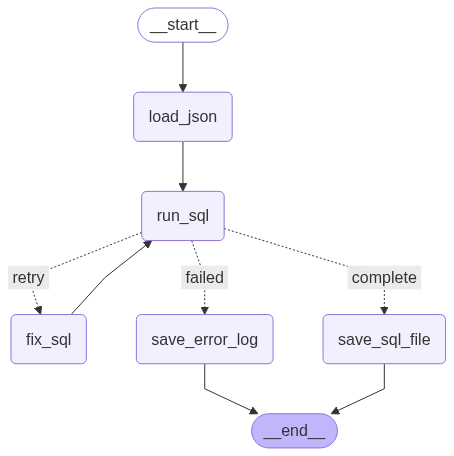

In [38]:
display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
import tempfile 

unit_test_map = {"location": unittest_location_table}

target_table  = "location"
test_fn = unit_test_map["location"]

initial_state: AgentState = {
    "conversation_history": [],
    "target_table": target_table,
    "test_result": (test_fn, False, ""),
    "sql_result": (False, ""),
    "temp_file": "",
    "retry_count": 0,
}

result = app.invoke(initial_state)

start load_json
0
```sql
-- Section 0 start
CREATE OR REPLACE VIEW omop.location_enriched_view AS
SELECT
    patients.city,
    patients.state,
    patients.zip,
    state_map.state_abbreviation
FROM synthea_source.patients
LEFT JOIN omop.state_map
    ON patients.state = state_map.state;
-- Section 0 end
```
✅ Ajouté 1 bloc(s) SQL pour l'étape 0 dans /tmp/tmp7hgn22kp.sql
1
```sql
-- Section 1 start
INSERT INTO omop.location (
    location_id,
    city,
    state,
    zip,
    location_source_value,
    address_1,
    address_2,
    county
)
SELECT DISTINCT
    -- Generate location_id using MD5 hash of combined fields cast to UUID
    CAST(
        MD5(
            CONCAT(
                COALESCE(city, ''),
                COALESCE(state_abbreviation, ''),
                COALESCE(zip, '')
            )
        ) AS UUID
    ) AS location_id,
    
    city,
    state_abbreviation AS state,
    zip,
    zip AS location_source_value,
    CAST(NULL AS VARCHAR) AS address_1,
    CAST(NULL